## DATA EXTRACTION

STEP1
- Code to extract and save movie-wise shen-parcellated fMRI data from the Human Connectome Project (HCP)'s social task dataset. The dataset has fMRI data from 1048 subjects.
- Task info: subjects watched 20s animations that were labelled by the experimenters and previous studies as "mental" and "random" - 5 stimuli/condition. Participants were asked to rate stimuli as mental, random or unsure after the end of the animation, 
- Our analysis of the behavioral data showed that although participants' reports in general agreed with the expter-assigned labels this was not always the case
- The fMRI data we obtained from the HCP online repository has been already preprocessed by them (motion corrected, unwarping, spatial normalization to MNI space etc. details in Barch et al, 2013, NI).
- Further, voxel-wise data has already been parcellated into 268 ROIs/nodes spanning the whole brain as per Shen parcellation.
- Here we begin by (1) removing subjects with missing runs, delayed stimulus presentations etc., and then move on to (2) temporally preprocess timecourses (Z-score normalization, trialwise baseline-correction), (3) isolate data from individual trials (t-x to t+28+y, where t is the first TR for a single trial/movie, and 28 volumes were acquired in 20s, and x/y are the nr of TRs before/after the movie)


TERMS/ABBREVIATIONS USED INTERCHANGEABLY:
- movie <-> trial
- mental <-> social <-> "yes" response/responder
- random <-> non-social <-> "no" response/responder
- nodes <-> regions of interest <-> ROIs
- subjects <-> participants <-> subs

@CODE REVIEWER: COMMENTS TO YOU START WITH "@CODE REVIEWER"

REKHA VARRIER, OCTOBER 2021

### Importing packages and parcellated fMRI data, exploring datatypes etc.

In [1]:
# import packages, check folders
#%reset
from pathlib import Path
from datetime import datetime
import os
import numpy as np
import h5py
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import time

%matplotlib inline

working_dir = '/Users/f0053cz/Dropbox (Dartmouth College)/postdoc_Dartmouth/HCP/fMRIScipts/code'

print('current directory:\n',working_dir)
path = Path(working_dir)
parent_folder = path.parent
data_file_loc = os.path.join(parent_folder,'data') # to store data we extract later in this notebook

fmri_dir = "/Users/f0053cz/Documents/HCP_SOCIALforRekha-001/HCP_SOCIALforRekha"
os.chdir(fmri_dir)
print('\nchanged current directory to:\n', fmri_dir)

''' # don't really need these, they're there just to explore data storage
folderName = os.path.join(fmri_dir,'indiv_data') # fMRI data is stored here
print("\nnumber of folders=",len(os.listdir(folderName)))

subj_folders = [i for i in os.listdir(folderName)]
print('subject folders',subj_folders[:10]) #beh data n=1051'''

current directory:
 /Users/f0053cz/Dropbox (Dartmouth College)/postdoc_Dartmouth/HCP/fMRIScipts/code

changed current directory to:
 /Users/f0053cz/Documents/HCP_SOCIALforRekha-001/HCP_SOCIALforRekha


' # don\'t really need these, they\'re there just to explore data storage\nfolderName = os.path.join(fmri_dir,\'indiv_data\') # fMRI data is stored here\nprint("\nnumber of folders=",len(os.listdir(folderName)))\n\nsubj_folders = [i for i in os.listdir(folderName)]\nprint(\'subject folders\',subj_folders[:10]) #beh data n=1051'

In [2]:
# setting default fontsizes for plots

s=16 # CHANGE FONTSIZE HERE

plt.rc('font', size=s) #controls default text size
plt.rc('axes', titlesize=s) #fontsize of the title
plt.rc('axes', labelsize=s) #fontsize of the x and y labels
plt.rc('xtick', labelsize=s) #fontsize of the x tick labels
plt.rc('ytick', labelsize=s) #fontsize of the y tick labels
plt.rc('legend', fontsize=s) #fontsize of the legend
#import matplotlib as mpl
#mpl.rcParams['font.weight']= 'normal'


From the plot above, it looks like timecourses are more similar across time within a node than across nodes - make sense - it could reflect firing props of neurons within that node or anything else typical of an roi

Now let's get working on the dataset. First we extract the data per run

## Extracting timecourses, subject indices

In [3]:
#extract fMRI data and subject names
f_RL = h5py.File("shen268_timecourses_RL.hdf5", "r") # dims: (subj*timecourseperrun*node), run 1 - first five movies
f_LR = h5py.File("shen268_timecourses_LR.hdf5", "r") # run 2 - next/last 5 movies

dat = {}
dat["run1"] = np.array(f_RL['shen268_timecourses'])
dat["run2"] = np.array(f_LR['shen268_timecourses'])
print('type(dat):',type(dat))

# subject list
subj_list = {}
subj_list["run1"] = [x.decode('utf8') for x in list(f_RL['subjlist'])] #RL--> order of subjects for run 1
subj_list["run2"] = [x.decode('utf8') for x in list(f_LR['subjlist'])] #LR
# Python string method decode() decodes the string using the codec registered for encoding.
# It defaults to the default string encoding.
print('type(subj_list):',type(subj_list))


type(dat): <class 'dict'>
type(subj_list): <class 'dict'>


## Exploring timecourses

In [4]:
# movies were presented in two runs, in the same order and at the same onset times (i.e., no jitter added)

vid_names = {}
vid_names["run1"] = ["COAXING-B", "BILLIARD-A", "DRIFTING-A", "Fishing", "Random mechanical"]#RL
vid_names["run2"] = ["Scaring", "SEDUCING-B", "STAR-A", "SURPRISING-B", "TENNIS-A"]#LR

vid_cat = {} # video category (mental/random or social/nonsocial)
vid_cat["run1"] = [1,0,0,1,0] # 1:mental,0: random
vid_cat["run2"] = [1,1,0,1,0]

## Import behavioral data

- Before extracting the data, let's also identify the behavioral data and remove impossibly short RTs (indicative of accidental button presses etc.)

In [5]:
#extract behavioral data, remove impossibly quick responses RT < 100ms
# approx 10 responses per subject, hence number of rows ~=10k
dir_name_beh = '/Users/f0053cz/Dropbox (Dartmouth College)/postdoc_Dartmouth/HCP/BehaviorAnalyses/Documented scripts/data/'
#beh_data = pd.read_csv(dir_name_beh + 'hcp_social_behav_for_ddm_stim-coding.csv')
beh_data = pd.read_csv(dir_name_beh + 'hcp_social_behav_for_ddm_stim-coding_corrected.csv')
rtmin = 0.1 # threshold for impossibly short RTs

print('nrows before=', beh_data.shape)
print("total subjects before=",len(np.unique(beh_data['subj_idx'])))

#beh_data_old = beh_data
beh_data= beh_data[beh_data["rt"]>=rtmin] # remove trials with RT<.1
print('\nnrows after=', beh_data.shape)
print("total subjects after=",len(np.unique(beh_data['subj_idx'])))
#print(np.where(beh_data.index == subj_shortRT[0]))
beh_data.head()

nrows before= (10149, 5)
total subjects before= 1051

nrows after= (10146, 5)
total subjects after= 1051


,subj_idx,stim,movie,rt,response
0,168745,Mental,Scaring.AVI,1.252,1
1,168745,Mental,SEDUCING-B.AVI,0.578,1
2,168745,Random,STAR-A.AVI,1.643,0
3,168745,Mental,SURPRISING-B.AVI,1.082,1
4,168745,Random,TENNIS-A.AVI,1.232,0


In [6]:
# import notebook from code 1_2_regressors
[timepts_indiv_movie,vid_start_rel_tr] = np.load(os.path.join(data_file_loc,'Video_TRs.npy'),allow_pickle=True)
# [timepts_indiv_movie,vid_start_rel_tr] 
#vid_start_rel_tr
print([len(i) for i in timepts_indiv_movie])
vid_start_rel_tr

[49, 56, 56, 56, 56, 49, 56, 56, 56, 56]


array([6, 13, 13, 13, 13, 6, 13, 13, 13, 13], dtype=object)

## Subject-wise preprocessing:
- finally coming to the main step
- Extraction of relevant TRs for each subject, normalizing and baseline-correcting it and store in a 4D array
- code below for both with run-wise norm. and trial-wise norm. (for different analyses later)

@CODE REVIEWER: FROM HERE ON, I'D LIKE YOU TO PLEASE VERIFY THAT THERE ARE NO ERRORS PLEASE

In [7]:
len(np.unique(beh_data['subj_idx']))

1051

In [9]:
# setting common variables for both types of preprocessing 

nsubj = len(subj_list['run1']) #1053 # total 1053 subs, but only 1048 will be in the final data (others have only one run or delayed stimulus presentation)
print('nsubj=',nsubj)
nnodes = 268 #268
#tr0_ind = 3 # timept at which t=0 for video
ntimepts = 56
nmovies = 10
n_init_TRs_to_delete = 5

nsubj= 1053


In [10]:
from scipy.signal import detrend

# 1. RUN-wise normalisation (Zscore) and then baseline correction.

In [12]:
#suff= ' '
suff = '_corrected'

In [15]:
print('vid_start_rel_tr=',vid_start_rel_tr,'\nsuff=',suff)

vid_start_rel_tr= [6 13 13 13 13 6 13 13 13 13] 
suff= _corrected


In [16]:
# run-wise normalization is more useful when comparing responses for the same movie. Within-trial comparison is 
# more useful for across-movie comparisons

start = time.time()

responses = np.empty((nsubj, nmovies))
responses[:] = np.nan # initialise responses with NaN
responses_rt = np.empty((nsubj, nmovies))
responses_rt[:] = np.nan # initialise responses with NaN
sub_id_all = [] # to save subject ID
Ynorm = np.empty((nsubj, nnodes, ntimepts, nmovies))
Ynorm[:] = np.nan
timecourses = np.empty((nsubj,nnodes,269,2))
timecourses[:] = np.nan

sub_ind = -1 # to store index of subject ID
for s1 in np.arange(0,nsubj):
    if s1 % 50 == 0: # printing occasional status updates
        now = time.time()
        print(f'subj:{s1},time elapsed:{(now - start)/60:.2f}mins')
    curr_subj = subj_list['run1'][s1] # Subject ID, e.g. '126628'
    
    try:
        s2 = subj_list['run2'].index(curr_subj)
        # see if the subject has data for run 2, if not don't count them (execution would go to except segment)

        # proceeding if sub has data for both runs
        curr_subj = int(curr_subj)
        sub_id_all.append(curr_subj) # save subject ID

        sub_ind += 1 # for each sub with both runs

        for vid_no in np.arange(10): # to store responses for each subject who has both runs
            run = 'run1' if vid_no < 5 else 'run2'
            vidName = vid_names[run][vid_no%5]
            vidName = '.'.join((vidName,'AVI')) # add .avi

            if ~((curr_subj == 105620) & (vid_no==0)) : 
                row = (beh_data['subj_idx'] == curr_subj) & (beh_data['movie'] == vidName)
                #print(len(np.where(row)[0]))
                if len(np.where(row)[0]) == 1: # unique row for that subj and movie
                    responses[sub_ind,vid_no] = beh_data.loc[row,'response']
                    responses_rt[sub_ind,vid_no] = beh_data.loc[row,'rt']
                elif len(np.where(row)[0]) > 1:
                    print('error!!!!') # error in behavioral data selection
            
            else:
                print('Beh: sub_ind:',sub_ind, ',vid_no:', vid_no, 'curr_subj:',curr_subj)

        # preproc step 1: within-run normalize each node
        for node in range(nnodes):
            tc_run1 = dat['run1'][s1,n_init_TRs_to_delete:,node] # data after removing first 5 TRs, so 274-5 TRs/run
            tc_run2 = dat['run2'][s2,n_init_TRs_to_delete:,node] 

            #runSlope[sub_ind,node,0] = np.polyfit(np.arange(tc_run1.shape[0]),tc_run1,1)[0]
            # linearly for the run, and save the slope for the run
            #runSlope[sub_ind,node,1] = np.polyfit(np.arange(tc_run2.shape[0]),tc_run2,1)[0]

            tc_run1 = detrend(tc_run1) # removing linear trends
            tc_run2 = detrend(tc_run2)
            tc_run1 = stats.zscore(tc_run1) # Z-score normalize values
            tc_run2 = stats.zscore(tc_run2)
            #tc_run1 = (tc_run1 - np.nanmean(tc_run1))/np.nanstd(tc_run1)
            #tc_run2 = (tc_run2 - np.nanmean(tc_run2))/np.nanstd(tc_run2)

            timecourses[sub_ind,node,:,0] = tc_run1
            timecourses[sub_ind,node,:,1] = tc_run2

            # baseline-correct each trial or movie
            for vid_no in np.arange(0,nmovies): 
                #run = 'run1' if vid_no < 5 else 'run2'
                if ~((curr_subj == 105620) & (vid_no==0)) : # this subject had a delayed stimulus presentation (removing for ease atm)
                    image_TRs = timepts_indiv_movie[vid_no] # TRs within run corresponding to vidno
                    Y = tc_run1[image_TRs] if vid_no<5 else tc_run2[image_TRs] # timecourse for a trial/vid_no

                    # baseline correction
                    if vid_no % 5 == 0:
                        Ynorm[sub_ind, node, :49, vid_no] = Y - Y[vid_start_rel_tr[vid_no]] #baseline correct w.r.t the first tr before stim onset and assign to a 4D array
                    else:
                        Ynorm[sub_ind, node, :  , vid_no] = Y - Y[vid_start_rel_tr[vid_no]] #baseline correct w.r.t the first tr before stim onset and assign to a 4D array
                else:
                    print('fMRI: node:', node, 'sub_ind:',sub_ind, ',vid_no:', vid_no, 'curr_subj:',curr_subj)

    except: # print error message if both runs aren't present (or there's another error in try)
            print(['only one subject for ind ',s1,', subjID:',curr_subj])

Ynorm = Ynorm[:sub_ind+1,:,:,:] # remove unused rows
responses = responses[:sub_ind+1,:]
responses_rt = responses_rt[:sub_ind+1,:]
timecourses = timecourses[:sub_ind+1,:,:,:]
#runSlope = runSlope[:sub_ind+1,:,:]

subj:0,time elapsed:0.04mins
subj:50,time elapsed:0.19mins
subj:100,time elapsed:0.34mins
Beh: sub_ind: 143 ,vid_no: 0 curr_subj: 105620
fMRI: node: 0 sub_ind: 143 ,vid_no: 0 curr_subj: 105620
fMRI: node: 1 sub_ind: 143 ,vid_no: 0 curr_subj: 105620
fMRI: node: 2 sub_ind: 143 ,vid_no: 0 curr_subj: 105620
fMRI: node: 3 sub_ind: 143 ,vid_no: 0 curr_subj: 105620
fMRI: node: 4 sub_ind: 143 ,vid_no: 0 curr_subj: 105620
fMRI: node: 5 sub_ind: 143 ,vid_no: 0 curr_subj: 105620
fMRI: node: 6 sub_ind: 143 ,vid_no: 0 curr_subj: 105620
fMRI: node: 7 sub_ind: 143 ,vid_no: 0 curr_subj: 105620
fMRI: node: 8 sub_ind: 143 ,vid_no: 0 curr_subj: 105620
fMRI: node: 9 sub_ind: 143 ,vid_no: 0 curr_subj: 105620
fMRI: node: 10 sub_ind: 143 ,vid_no: 0 curr_subj: 105620
fMRI: node: 11 sub_ind: 143 ,vid_no: 0 curr_subj: 105620
fMRI: node: 12 sub_ind: 143 ,vid_no: 0 curr_subj: 105620
fMRI: node: 13 sub_ind: 143 ,vid_no: 0 curr_subj: 105620
fMRI: node: 14 sub_ind: 143 ,vid_no: 0 curr_subj: 105620
fMRI: node: 15 sub

In [17]:
sub_ind

1048

In [24]:
timecourses.shape

(1049, 268, 269, 2)

In [27]:
x = np.load(os.path.join(data_file_loc,f'timecourses_corrected.npy'))
x.shape

(1049, 268, 269, 2)

In [25]:
x = np.load(os.path.join(data_file_loc,f'timecourses_corrected.npy'))
x.shape

'_corrected'

In [26]:
data_file_loc

'/Users/f0053cz/Dropbox (Dartmouth College)/postdoc_Dartmouth/HCP/fMRIScipts/data'

In [ ]:
if sub_ind == 1048: # i.e., nrows of all files is 1049, suff = "_corrected"
    np.save(os.path.join(data_file_loc,'timecourses_run_norm',f'timecourse-all-movies_zscorenorm{suff}.npy'), Ynorm) # save timecourses
    np.save(os.path.join(data_file_loc,f'responses{suff}.npy'), responses) # save beh responses
    np.save(os.path.join(data_file_loc,f'responses_rt{suff}.npy'), responses_rt) # save beh responses
    np.save(os.path.join(data_file_loc,f'timecourses{suff}.npy'), timecourses) # save run timecourses (for all movie LMs)
    np.save(os.path.join(data_file_loc,f'sub_ID_all{suff}.npy'), sub_id_all) # save run timecourses (for all movie LMs)
print('\n\nData saved on/at:',datetime.now()) # cell run at

In [16]:
np.where(np.array(sub_id_all)==105620)

(array([143]),)

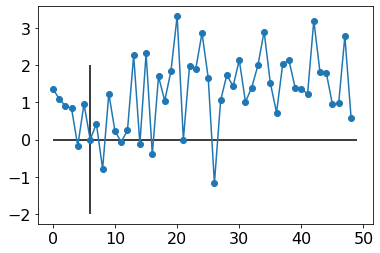

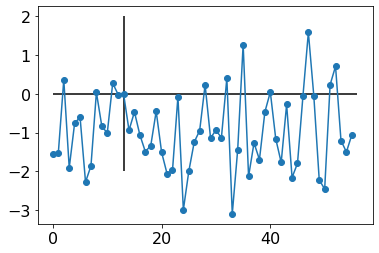

In [16]:
plt.figure(1)
plt.hlines(0,0,49,color='k')
plt.vlines(vid_start_rel_tr[0],-2,2,color='k')
plt.plot(Ynorm[0,0,:,0],marker = 'o')

plt.figure(2)
plt.hlines(0,0,56,color='k')
plt.vlines(vid_start_rel_tr[1],-2,2,color='k')
plt.plot(Ynorm[0,0,:,1],marker = 'o')


# 2. TRIAL-wise normalisation (Zscore) and then baseline correction.

In [17]:
vid_start_rel_tr

array([6, 13, 13, 13, 13, 6, 13, 13, 13, 13], dtype=object)

In [15]:
# trial-wise normalization is more useful when comparing responses across movies
# takes over 10 mins!!

start = time.time()

Ynorm = np.empty((nsubj, nnodes, ntimepts, nmovies))
Ynorm[:] = np.nan

sub_ind = -1 # to store index of subject ID
for s1 in np.arange(0,nsubj):
    if s1 % 50 == 0: # printing occasional status updates
        now = time.time()
        print(f'subj:{s1},time elapsed:{(now - start)/60:.2f}mins')
    curr_subj = subj_list['run1'][s1] # Subject ID, e.g. '126628'
    
    try:
        s2 = subj_list['run2'].index(curr_subj)
        # see if the subject has data for run 2, if not don't count them (execution would go to except segment)

        # proceeding if sub has data for both runs
        curr_subj = int(curr_subj)
        #sub_id_all.append(curr_subj)
        sub_ind += 1 # for each sub with both runs

        # preproc step 1: within-run normalize each node
        for node in range(nnodes):
            tc_run1 = dat['run1'][s1,n_init_TRs_to_delete:,node] # data after removing first 5 TRs, so 274-5 TRs/run
            tc_run2 = dat['run2'][s2,n_init_TRs_to_delete:,node] 

            tc_run1 = detrend(tc_run1) # removing linear trends
            tc_run2 = detrend(tc_run2)
            
            # normalize and baseline-correct each trial or movie
            for vid_no in np.arange(0,nmovies): 
                if ~((curr_subj == 105620) & (vid_no==0)) : 
                    run = 'run1' if vid_no < 5 else 'run2'
                    image_TRs = timepts_indiv_movie[vid_no] # TRs within run corresponding to vidno
                    Y = tc_run1[image_TRs] if run == 'run1' else tc_run2[image_TRs] # timecourse for a trial/vid_no
                    Y = stats.zscore(Y)
                    #vid_inds = np.arange(vid_start_rel_tr[vid_no],vid_start_rel_tr[vid_no]+l_task)
                    #Y[vid_inds] = stats.zscore(Y[vid_inds])
                    
                    # baseline correction
                    if vid_no % 5 == 0:
                        Ynorm[sub_ind,node,:49,vid_no] = Y - Y[vid_start_rel_tr[vid_no]] #baseline correct and assign to a 4D array
                    else:
                        Ynorm[sub_ind,node,:,vid_no]   = Y - Y[vid_start_rel_tr[vid_no]] #baseline correct and assign to a 4D array
                
                else:
                    print('fMRI: node:', node, 'sub_ind:',sub_ind, ',vid_no:', vid_no, 'curr_subj:',curr_subj)

    except: # print error message if both runs aren't present (or there's another error in try)
            print(['only one subject for ind ',s1,', subjID:',curr_subj])

Ynorm = Ynorm[:sub_ind+1,:,:,:] # remove unused rows

if sub_ind == 1048:
    np.save(os.path.join(data_file_loc,'timecourses_trial_norm',f'timecourse-all-movies_zscorenorm{suff}.npy'), Ynorm) # save timecourses

print('\n\nData saved on/at:',datetime.now()) # cell run at

subj:0,time elapsed:0.01mins
subj:50,time elapsed:0.26mins
subj:100,time elapsed:0.50mins
fMRI: node: 0 sub_ind: 143 ,vid_no: 0 curr_subj: 105620
fMRI: node: 1 sub_ind: 143 ,vid_no: 0 curr_subj: 105620
fMRI: node: 2 sub_ind: 143 ,vid_no: 0 curr_subj: 105620
fMRI: node: 3 sub_ind: 143 ,vid_no: 0 curr_subj: 105620
fMRI: node: 4 sub_ind: 143 ,vid_no: 0 curr_subj: 105620
fMRI: node: 5 sub_ind: 143 ,vid_no: 0 curr_subj: 105620
fMRI: node: 6 sub_ind: 143 ,vid_no: 0 curr_subj: 105620
fMRI: node: 7 sub_ind: 143 ,vid_no: 0 curr_subj: 105620
fMRI: node: 8 sub_ind: 143 ,vid_no: 0 curr_subj: 105620
fMRI: node: 9 sub_ind: 143 ,vid_no: 0 curr_subj: 105620
fMRI: node: 10 sub_ind: 143 ,vid_no: 0 curr_subj: 105620
fMRI: node: 11 sub_ind: 143 ,vid_no: 0 curr_subj: 105620
fMRI: node: 12 sub_ind: 143 ,vid_no: 0 curr_subj: 105620
fMRI: node: 13 sub_ind: 143 ,vid_no: 0 curr_subj: 105620
fMRI: node: 14 sub_ind: 143 ,vid_no: 0 curr_subj: 105620
fMRI: node: 15 sub_ind: 143 ,vid_no: 0 curr_subj: 105620
fMRI: no

In [55]:
sub_id_all[143]

105620

# Sanity checks

In [53]:
print(sub_id_all.index(105620))
print(responses[143,:])
print(responses_rt[143,:])
Ynorm[143,0,:,0] 
# verifying that this sub has NaNs for COAXING, but values for all else

143
[nan  0.  0.  1.  0.  1.  1.  0.  1.  0.]
[  nan 1.327 0.586 2.657 0.93  0.562 0.588 0.457 0.805 0.61 ]


array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan])

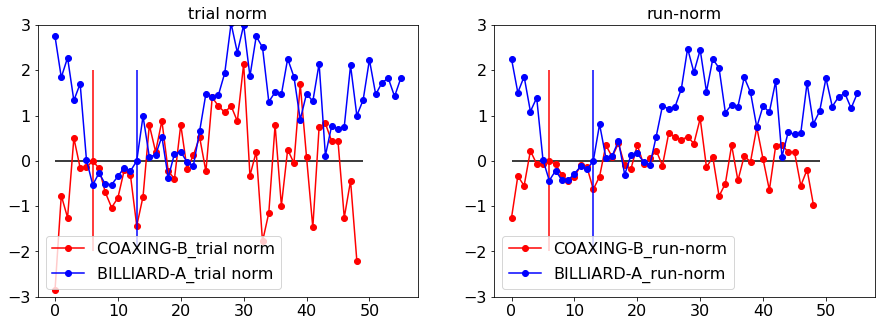

In [54]:
plt.figure(1,figsize=(15,5))
n=65
title = ['trial norm','run-norm']
for ind in range(2):
    if ind == 0:
        Ynorm = np.load(os.path.join(data_file_loc,'timecourses_trial_norm',f'timecourse-all-movies_zscorenorm{suff}.npy'))
    else:
        Ynorm = np.load(os.path.join(data_file_loc,'timecourses_run_norm',f'timecourse-all-movies_zscorenorm{suff}.npy'))

    plt.subplot(1,2,ind+1)
    plt.hlines(0,0,49,color='k')
    plt.vlines(vid_start_rel_tr[0],-2,2,color = 'r')
    plt.plot(Ynorm[0,n,:,0],marker = 'o',color = 'r',label = vid_names['run1'][0] +  '_' + title[ind])
    
    plt.vlines(vid_start_rel_tr[1],-2,2,color='b')
    plt.plot(Ynorm[0,n,:,1],marker = 'o',color = 'b',label = vid_names['run1'][1] + '_' + title[ind])
    plt.ylim(-3,3)
    plt.title(title[ind])
    plt.legend()


array([        nan, -0.90923003,  2.89356614,  2.09221406, -0.28926285,
               nan,  0.85306412,  1.8421299 ,  0.13717167,  1.31634213])

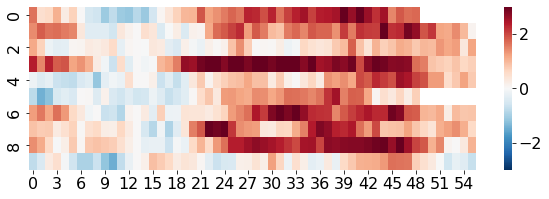

In [44]:
Ynorm = np.load(os.path.join(data_file_loc,'timecourses_run_norm',f'timecourse-all-movies_zscorenorm{suff}.npy'))
s,n = 1,65
plt.figure(1,figsize=(10,3))
sns.heatmap(Ynorm[s,n,:,:].T,cmap = 'RdBu_r',vmin = -3, vmax = 3) # timepts*movie
Ynorm[0,0,-1,:] # in the heatmap, looks like the last timept is NaN, but it's not (as printed below)

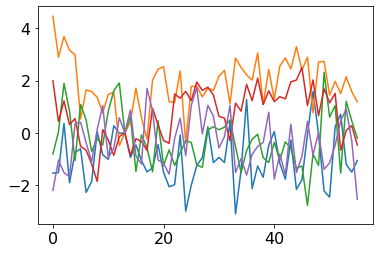

In [45]:
Ynorm =  np.load(os.path.join(data_file_loc,'timecourses_trial_norm',f'timecourse-all-movies_zscorenorm{suff}.npy'))
plt.plot(Ynorm[:5,0,:,1].T)

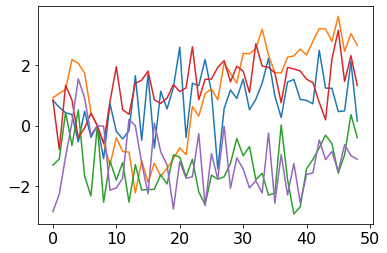

In [35]:
Ynorm =  np.load(os.path.join(data_file_loc,'timecourses_run_norm',f'timecourse-all-movies_zscorenorm.npy'))
plt.plot(Ynorm[:5,0,:,0].T)

In [36]:
timecourses = np.load(os.path.join(data_file_loc,'timecourses.npy'))
timecourses[0,0,:5,:] # see if values are distinct

array([[ 0.00364855,  0.66507549],
       [-0.2293776 , -0.76939139],
       [-0.40624693,  1.50187307],
       [-0.46695373, -0.18351192],
       [-1.36892794, -0.92859621]])

## Is there a linear trend?
- this step was done when the above code did not contain a detrending step.
- don't need to run it now that the data has already been detrended

Ttest_1sampResult(statistic=-49.98950663403359, pvalue=0.0)
nr. of nodes with a slope sig different from 0 in run 1:
210
nr. of nodes with a slope sig different from 0 in run 2
228
Slope run 1: mean: -0.03899181115291593 Ttest_1sampResult(statistic=-49.98950663403359, pvalue=0.0)
Slope run 2: mean: -0.07717801757289106 Ttest_1sampResult(statistic=-95.89548049424342, pvalue=0.0)


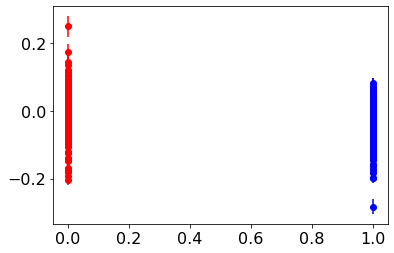

In [28]:
# no need to run this now

plt.figure(1)
plt.errorbar(np.zeros((268,)),np.nanmedian(runSlope[:,:,0],axis=0),stats.sem(runSlope[:,:,0],axis=0),
             marker ='o',color = 'r',ls = 'None')
plt.errorbar(np.ones((268,)),np.nanmedian(runSlope[:,:,1],axis=0),stats.sem(runSlope[:,:,1],axis=0),
             marker ='o',color = 'b',ls = 'None')
print(stats.ttest_1samp(np.ndarray.flatten(runSlope[:,:,0]),0))

print('nr. of nodes with a slope sig different from 0 in run 1:')
print(sum([1 if stats.ttest_1samp(runSlope[:,n,0],0)[1]<.05 else 0 for n in range(268)]))

print('nr. of nodes with a slope sig different from 0 in run 2')    
print(sum([1 if stats.ttest_1samp(runSlope[:,n,1],0)[1]<.05 else 0 for n in range(268)]))


print('Slope run 1: mean:',np.nanmean(np.ndarray.flatten(runSlope[:,:,0])),stats.ttest_1samp(np.ndarray.flatten(runSlope[:,:,0]),0))
print('Slope run 2: mean:',np.nanmean(np.ndarray.flatten(runSlope[:,:,1])),stats.ttest_1samp(np.ndarray.flatten(runSlope[:,:,1]),0))

# example detrending
plt.figure(2)
from scipy.signal import detrend
x = dat['run1'][0,n_init_TRs_to_delete:,0]
plt.figure(1, figsize = (25,5))
plt.plot(x)
plt.plot(detrend(x,type= 'linear'))

- Looks like the slope in all nodes is sig < zero, although the magnitude is very small. So we should detrend before normalizing etc.
- ^^**this has been done already**

In [ ]:
# this code snippet helped determine that the first 5 TRs of a run need to be removed. 
# # this has been done already, so can be run as a sanity check, but is optional
# first 5 TRs of the run

plt.figure(1,figsize =(15,10))
for run in range(2):
    plt.subplot(2,1,run+1)
    plt.title(f'Run{run+1}',fontsize =24)
    for n in np.arange(0,268):
        plt.errorbar(range(10), np.nanmedian(all_runs_z[:,n,:10,run],axis=0),
                     stats.sem(all_runs_z[:,n,:10,run],axis=0,nan_policy='omit'))
                     #color = 'k',alpha = .1)
    ymin,ymax = plt.ylim()
    for i in range(5):
        plt.axvspan(vid_onsets_imagenr[i],vid_onsets_imagenr[i]+28, color = 'red', alpha = .1, label = 'stim')  #vertical shading

    plt.xlim(0,10)
plt.tight_layout()